In [47]:
# importing required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import boxcox1p

from sklearn.compose import ColumnTransformer
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBRegressor

In [48]:
# loading data from source CSV files
stu_por = pd.read_csv('student-por.csv', sep=';')
stu_mat = pd.read_csv('student-mat.csv', sep=';')

In [49]:
pd.pandas.set_option('display.max_columns', None)

In [50]:
# merging data from both the files
stu=pd.concat([stu_por,stu_mat])

In [51]:
stu.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [52]:
stu.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


## Looking at each variable and try to understand their meaning and relevance to this problem

### Analysing 'absences'

In [53]:
stu['absences'].describe()

count    1044.000000
mean        4.434866
std         6.210017
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max        75.000000
Name: absences, dtype: float64

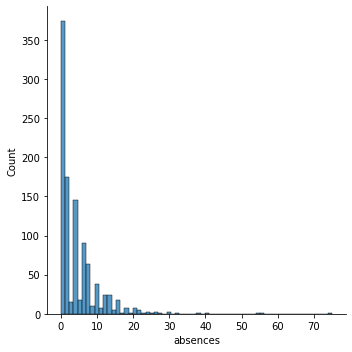

In [54]:
sns.displot(stu['absences'])

### Observation:
* Not normally distribution.
* Have positive skewness.
* Show peakedness.

In [55]:
print("Skewness: %f" % stu['absences'].skew())
print("Kurtosis: %f" % stu['absences'].kurt())

Skewness: 3.741347
Kurtosis: 26.596200


## Statistical Hypothesis testing

We expect the given sample data is part of an underlying population or distribution. However the sample data could be different from the population in some way. So we go for Hypothesis testing. Statistical Hypothesis testing helps us confirm if assumptions or hypothesis ( Null hypothesis) is correct.

Significance level: prob threshold - when to reject the null hypothesis.
prob of getting a result as extreme as the one we observe due to chance is lower than the significance level, we reject the null hypothesis in favor of alternate hypothesis.

#### T-test
determine a numeric data sample differs significantly from the population 
or 2 samples differ from one another.

### One-Sample T-test
Null hypothesis: 
sample average of the absences is same from the population average of absences

Alternate hypothesis:
sample average of absences is different from the population average of absences

* checking if the given sample average is differ from the population average of absences
* 95% confidence interval

t-stats outside the range -> reject null to accept alternate hypothesis
if p-value less than 0.05 -> reject null to accept alternate hypothesis

a p-value of 0.01311 means we would expect to see data as extreme as our sample due to chance about 1.3% of the time if the null hypothesis was true.

### 1. Two-Sample T-test
Null hypothesis: 
average of the absences is same for male and female students

Alternate hypothesis: 
average of the absences is different for male and female students


In [56]:
# performing 2 sample ttest
stats.ttest_ind(a = stu[stu['sex'] == 'F']['absences'], b = stu[stu['sex'] == 'M']['absences'], equal_var=False)

Ttest_indResult(statistic=0.43688259666936907, pvalue=0.6622870114184785)

### Obsersation
* The T-test yields a p-value greater than 0.05. This means there is more than 66% chance we'd see sample data this far apart if the two groups tested are actually identical.
* As we are using 95% confidence level we would fail to reject the null hypothesis.
* This says average of the absences is not very different for male and female students

### 2. Two-Sample T-test
Null hypothesis: 
average of the absences is same for students of 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira schools

Alternate hypothesis: 
average of the absences is different for students of 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira

In [57]:
# performing 2 sample ttest
stats.ttest_ind(a = stu[stu['school'] == 'GP']['absences'], b = stu[stu['school'] == 'MS']['absences'], equal_var=False)

Ttest_indResult(statistic=6.851847659437831, pvalue=1.3198492622687381e-11)

### Obsersation
* The T-test yields a p-value less than 0.05. 
* As we are using 95% confidence level we would reject the null hypothesis.
* This says average of the absences is different for students of 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira

In [58]:
print(stu[stu['school'] == 'GP']['absences'].mean())
print(stu[stu['school'] == 'MS']['absences'].mean())

5.006476683937824
2.8125


### Chi-Squared Goodness-Of-Fit Test
* functions on the categorical features
* Tests whether the distribution of the categorical feature matches an expected distribution

### Chi-Squared Test of Independence
* functions on the categorical features
* Tests whether two categorical features are independent
* if p-value is too high, we cannot reject the hypothesis two categorical features are independent of one another.


In [59]:
stu_tab = pd.crosstab(stu['school'], stu['sex'], margins=True)
stu_tab.columns = ['F', 'M','Row_Total']
stu_tab.index = ['GP', 'MS', 'Col_Total']
observed = stu_tab.iloc[0:2,0:2]
stu_tab

,F,M,Row_Total
GP,420,352,772
MS,171,101,272
Col_Total,591,453,1044


In [60]:
expected = np.outer(stu_tab['Row_Total'][0:2], stu_tab.loc['Col_Total'][0:2])/1044
expected = pd.DataFrame(expected)
expected.columns = ['F', 'M']
expected.index = ['GP','MS']
expected

,F,M
GP,437.022989,334.977011
MS,153.977011,118.022989


In [61]:
stats.chi2_contingency(observed=observed)

(5.525948208639177,
 0.018736445448117065,
 1,
 array([[437.02298851, 334.97701149],
        [153.97701149, 118.02298851]]))

## Observation:
* as the p-value is less than 0.05, we can reject the hypothesis the 'school' and 'sex' feature are independent of one another.
* this test detects a significant relationship between 'school' and 'sex' feature

## Feature Engineering

## Missing data


In [62]:
#missing data
total = stu.isnull().sum().sort_values(ascending=False)
percent = (stu.isnull().sum()/stu.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
school,0,0.0
paid,0,0.0
G2,0,0.0
G1,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0
Dalc,0,0.0
goout,0,0.0
freetime,0,0.0


### Observation:
* Data is good from missing values stand point.
* All observations have values for all features.
* No imputation required.

### Univariate analysis

In [63]:
# standardizing data 
# mean of 0 and a standard deviation of 1.
absences_scaled = StandardScaler().fit_transform(stu['absences'][:,np.newaxis]);
low_range = absences_scaled[absences_scaled[:,0].argsort()][:30]
high_range= absences_scaled[absences_scaled[:,0].argsort()][-30:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]
 [-0.71448946]]

outer range (high) of the distribution:
[[ 2.18544272]
 [ 2.18544272]
 [ 2.34655006]
 [ 2.50765741]
 [ 2.50765741]
 [ 2.50765741]
 [ 2.50765741]
 [ 2.66876475]
 [ 2.66876475]
 [ 2.66876475]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.82987209]
 [ 2.99097944]
 [ 3.15208678]
 [ 3.15208678]
 [ 3.31319412]
 [ 3.47430147]
 [ 3.47430147]
 [ 3.79651615]
 [ 4.11873084]
 [ 4.11873084]
 [ 4.44094553]
 [ 5.40758959]
 [ 5.72980427]
 [ 7.98530708]
 [ 8.30752177]
 [11.3685613 ]]


C:\Users\snara016\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Observation:
Low range values are similar and not too far from 0. High range values are far from 0 and the values above 2.something values are really out of range. We will take care of those outliers below

## Outliers

In [64]:
# dropping the records that have absences that are more than 18 because of less frequency
stu = stu.drop(stu[stu['absences']>18].index)

## Understanding pattern in proportion of the absences with respect to other features

In [65]:
stu['abs_yes'] = stu['absences'] > 0

In [66]:
for feature in stu.columns:
    if feature != 'abs_yes' and feature != 'absences':
        print(stu.groupby(feature).agg({'abs_yes': ['mean', 'sum', 'count']}))

         abs_yes           
            mean  sum count
school                     
GP      0.669456  480   717
MS      0.580882  158   272
      abs_yes           
         mean  sum count
sex                     
F    0.640934  357   557
M    0.650463  281   432
      abs_yes           
         mean  sum count
age                     
15   0.605263  115   190
16   0.639405  172   269
17   0.647287  167   258
18   0.679426  142   209
19   0.640000   32    50
20   0.777778    7     9
21   0.500000    1     2
22   1.000000    2     2
          abs_yes           
             mean  sum count
address                     
R        0.648551  179   276
U        0.643759  459   713
          abs_yes           
             mean  sum count
famsize                     
GT3      0.647564  452   698
LE3      0.639175  186   291
          abs_yes           
             mean  sum count
Pstatus                     
A        0.684211   78   114
T        0.640000  560   875
       abs_yes           

In [67]:
stu = stu.drop(columns=['abs_yes'])

# Feature Selection
## Numerical Features

## Correlation matrix (heatmap style)

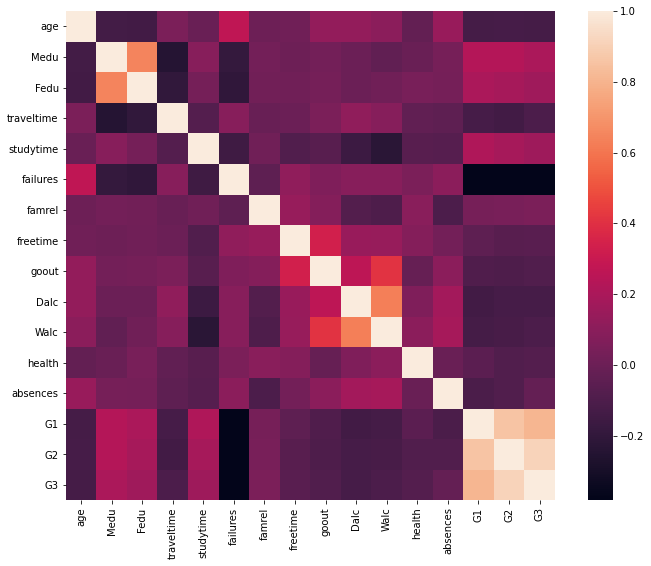

In [68]:
corrmat = stu.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

## Observation: 
* Grades G1,G2,G3 are highly correlated
* Alcohol consumption 'Dalc' and 'Walc' are correlated.

## 'absences' correlation matrix (zoomed heatmap style)
### Top 10 numerical feature that are correlated with absences

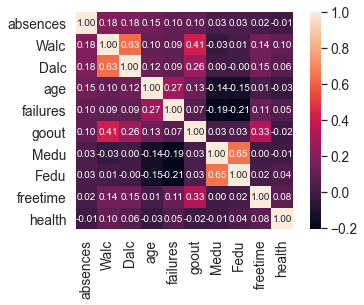

In [69]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'absences')['absences'].index
cm = np.corrcoef(stu[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Observation
### Expected to see some corellation with absences and other numeric feature. However not seeing much correction
* From the above matrix, we see 'Walc' and 'Dalc' are strongly correlated variables. 
* Also we see 'Medu' and 'Fedu' are correlated variables.

# Feature Selection
## Categorical Features

In [70]:
categorical_features = np.setdiff1d(stu.columns,corrmat.columns)

## Box Plots with Categorical features

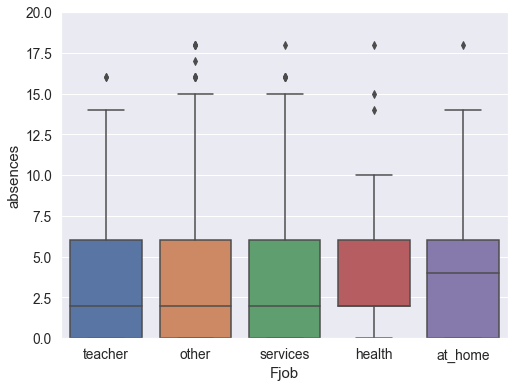

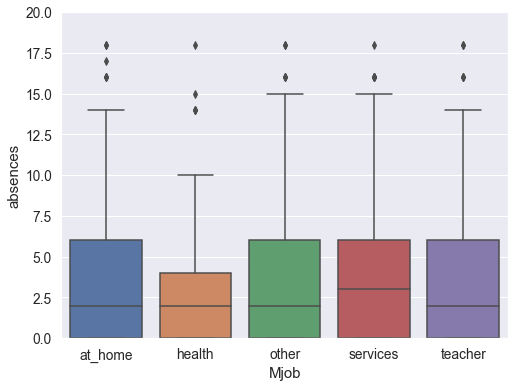

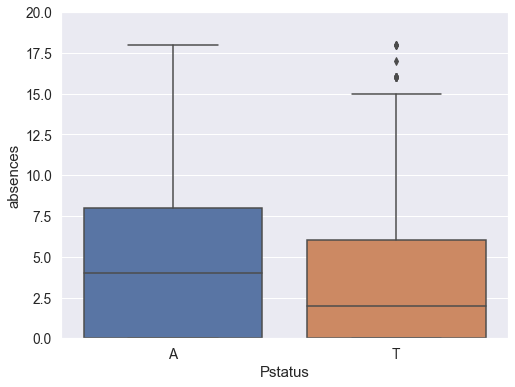

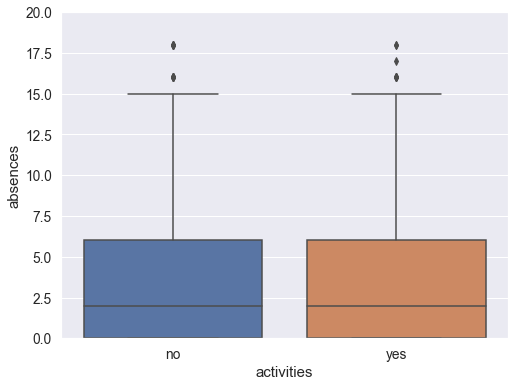

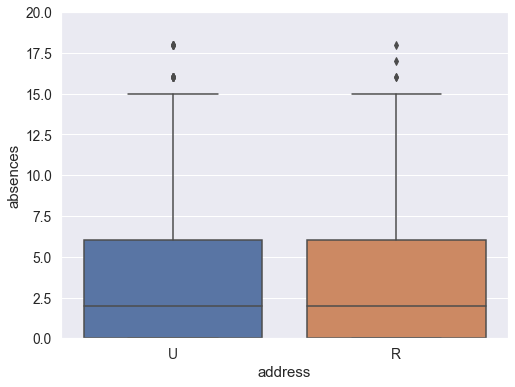

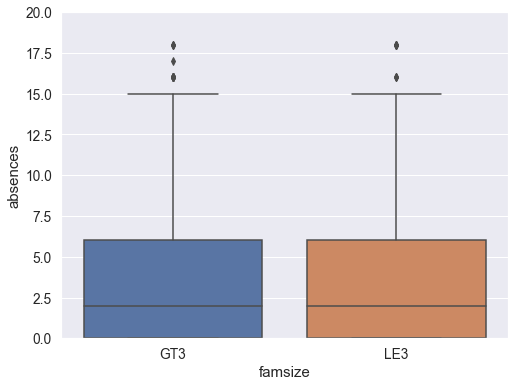

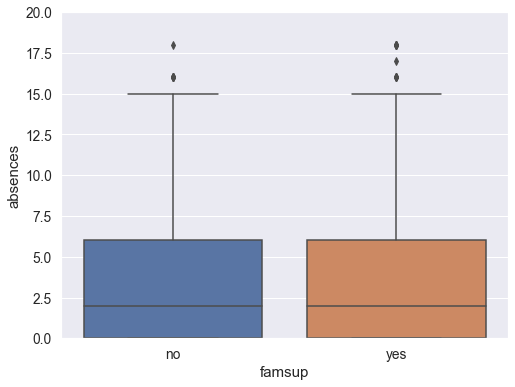

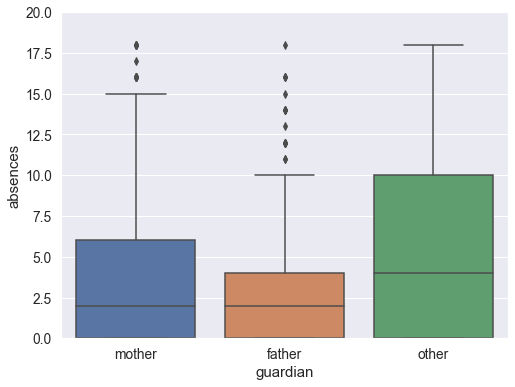

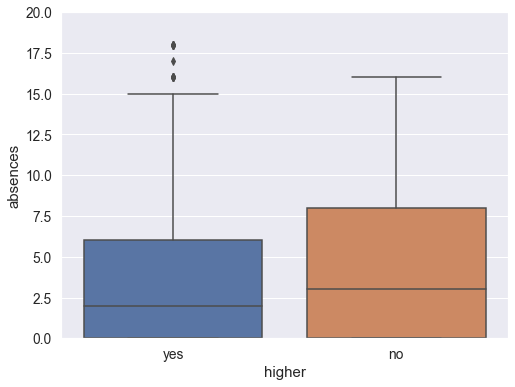

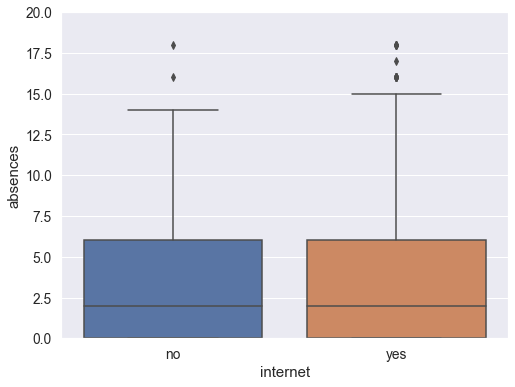

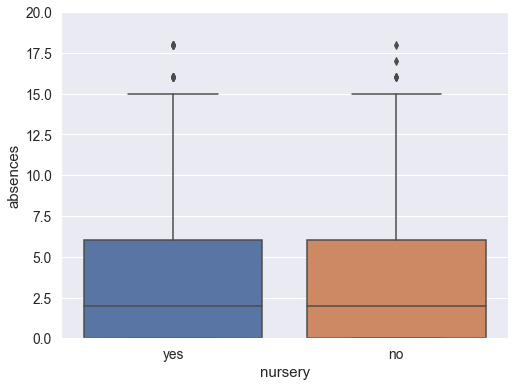

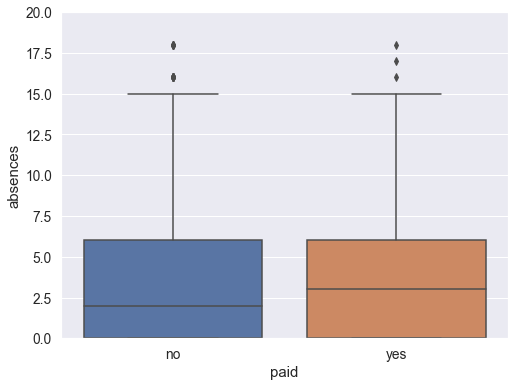

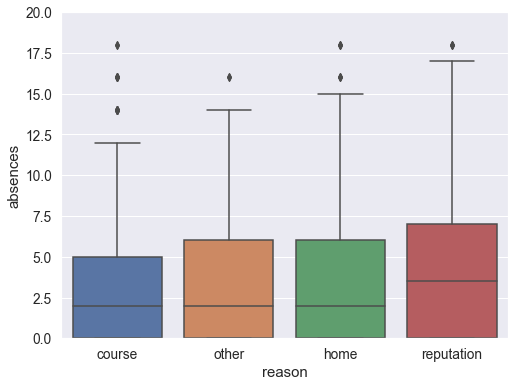

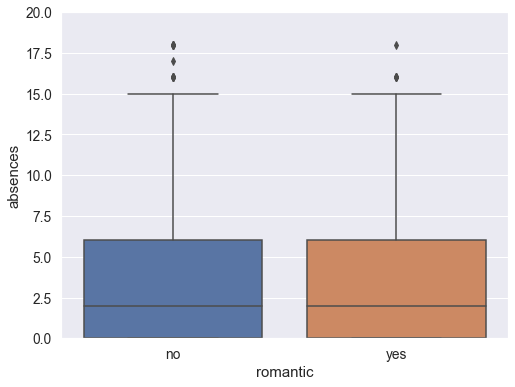

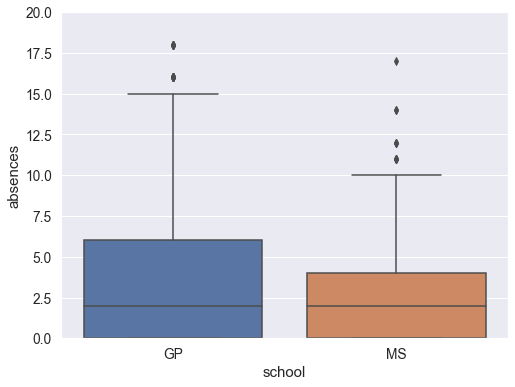

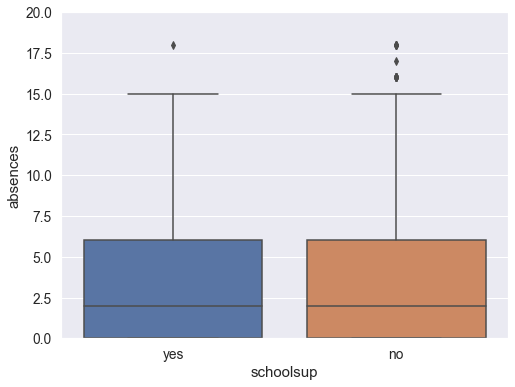

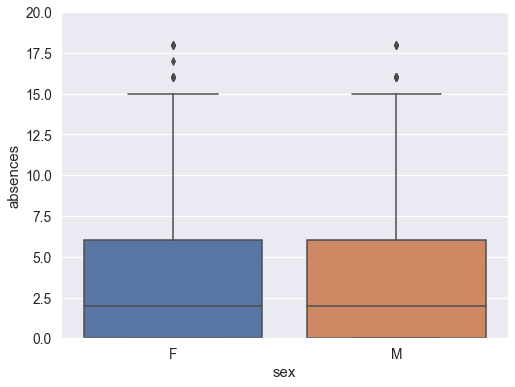

In [71]:
for feature in categorical_features:
        data = pd.concat([stu['absences'], stu[feature]], axis=1)
        f, ax = plt.subplots(figsize=(8,6))
        fig = sns.boxplot(x=feature, y='absences', data=data)
        fig.axis(ymin=0, ymax=20)

### Observation:
* same with categorical features as well. No much interesting relationships found. 
* From the above box plots, we see 'Mjob', 'Pstatus', 'guardian', 'higher', 'nursery', 'paid', 'reason', 'romantic' have some relation with absences. 

In [117]:
X = stu.drop(columns=['absences'])
y = stu['absences']

In [118]:
# One hot encoding
X = pd.get_dummies(X)
X = X.drop(columns = ['school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other', 'schoolsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes', 'G1', 'G2' ])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

In [120]:
X_train.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'G3', 'school_GP',
       'sex_F', 'address_R', 'famsize_GT3', 'Pstatus_A', 'Mjob_at_home',
       'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'schoolsup_no', 'famsup_no', 'famsup_yes', 'paid_no',
       'activities_no', 'nursery_no', 'higher_no', 'internet_no',
       'romantic_no'],
      dtype='object')

## Modeling 
* Mean squared error is used as Evaluation metrics for model selection

## ElasticNet Regression
ElasticNet is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods.

In [121]:
elasticNet_model = ElasticNet(random_state=0)

#### Hyperparameter tuning

In [137]:
search_space = [{'elasticNet_model': [elasticNet_model],
                    'elasticNet_model__max_iter': [1, 5, 10, 100, 1000, 10000, 100000],
                    'elasticNet_model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                    'elasticNet_model__l1_ratio': np.arange(0.0, 1.0, 0.1)}]

In [138]:
pipe0 = Pipeline(steps=[('elasticNet_model', elasticNet_model)])

In [139]:
elasticNet_GSCV = GridSearchCV(pipe0, search_space, cv=5, verbose=2, n_jobs = -1)

In [140]:
best_model_elasticNet = elasticNet_GSCV.fit(X_train, y_train)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2285 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2450 out of 2450 | elapsed:   23.3s finished
C:\Users\snara016\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5853.203815238361, tolerance: 1.2367299132947984
  positive)


In [145]:
print(best_model_elasticNet.best_estimator_.get_params()['elasticNet_model'])

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.0, max_iter=1,
           normalize=False, positive=False, precompute=False, random_state=0,
           selection='cyclic', tol=0.0001, warm_start=False)


In [146]:
y_pred_best_model_elasticNet = best_model_elasticNet.predict(X_test)

In [147]:
mse_elasticNetReg = metrics.mean_squared_error(y_test,y_pred_best_model_elasticNet)

In [148]:
print(np.sqrt(mse_elasticNetReg))

4.114176890301781


## Observation:
* Root Mean Square Error is too high.

## RandomForest Regression
As ElasticNet regression did not go well. Trying Random Forest Regression uses ensemble learning method for regression trees.

In [149]:
RFReg = RandomForestRegressor(random_state=0)

#### Hyperparameter tuning

In [150]:
# Number of trees in random forest
n_estimators = [100, 200, 300, 500, 800, 1000, 1800]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2,4,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [151]:
search_space = [{'RFReg': [RFReg],
                    'RFReg__n_estimators': n_estimators,
                    'RFReg__max_features': max_features,
                    'RFReg__min_samples_split': min_samples_split,
                    'RFReg__min_samples_leaf': min_samples_leaf,
                    'RFReg__bootstrap': bootstrap}]

In [152]:
pipe1 = Pipeline(steps=[('RFReg', RFReg)])

In [153]:
RF_GSCV = GridSearchCV(pipe1, search_space, cv=3, verbose=2, n_jobs = -1)

In [155]:
best_model_RF = RF_GSCV.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:  5.0min finished


In [157]:
print(best_model_RF.best_estimator_.get_params()['RFReg'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [158]:
y_pred_best_model_RF = best_model_RF.predict(X_test)

In [159]:
mse_RFBReg = metrics.mean_squared_error(y_test,y_pred_best_model_RF)

In [160]:
print(print(np.sqrt(mse_RFBReg)))

3.897605146089178
None


In [163]:
sorted_idx = best_model_RF.best_estimator_.get_params()['RFReg'].feature_importances_.argsort()

<BarContainer object of 40 artists>

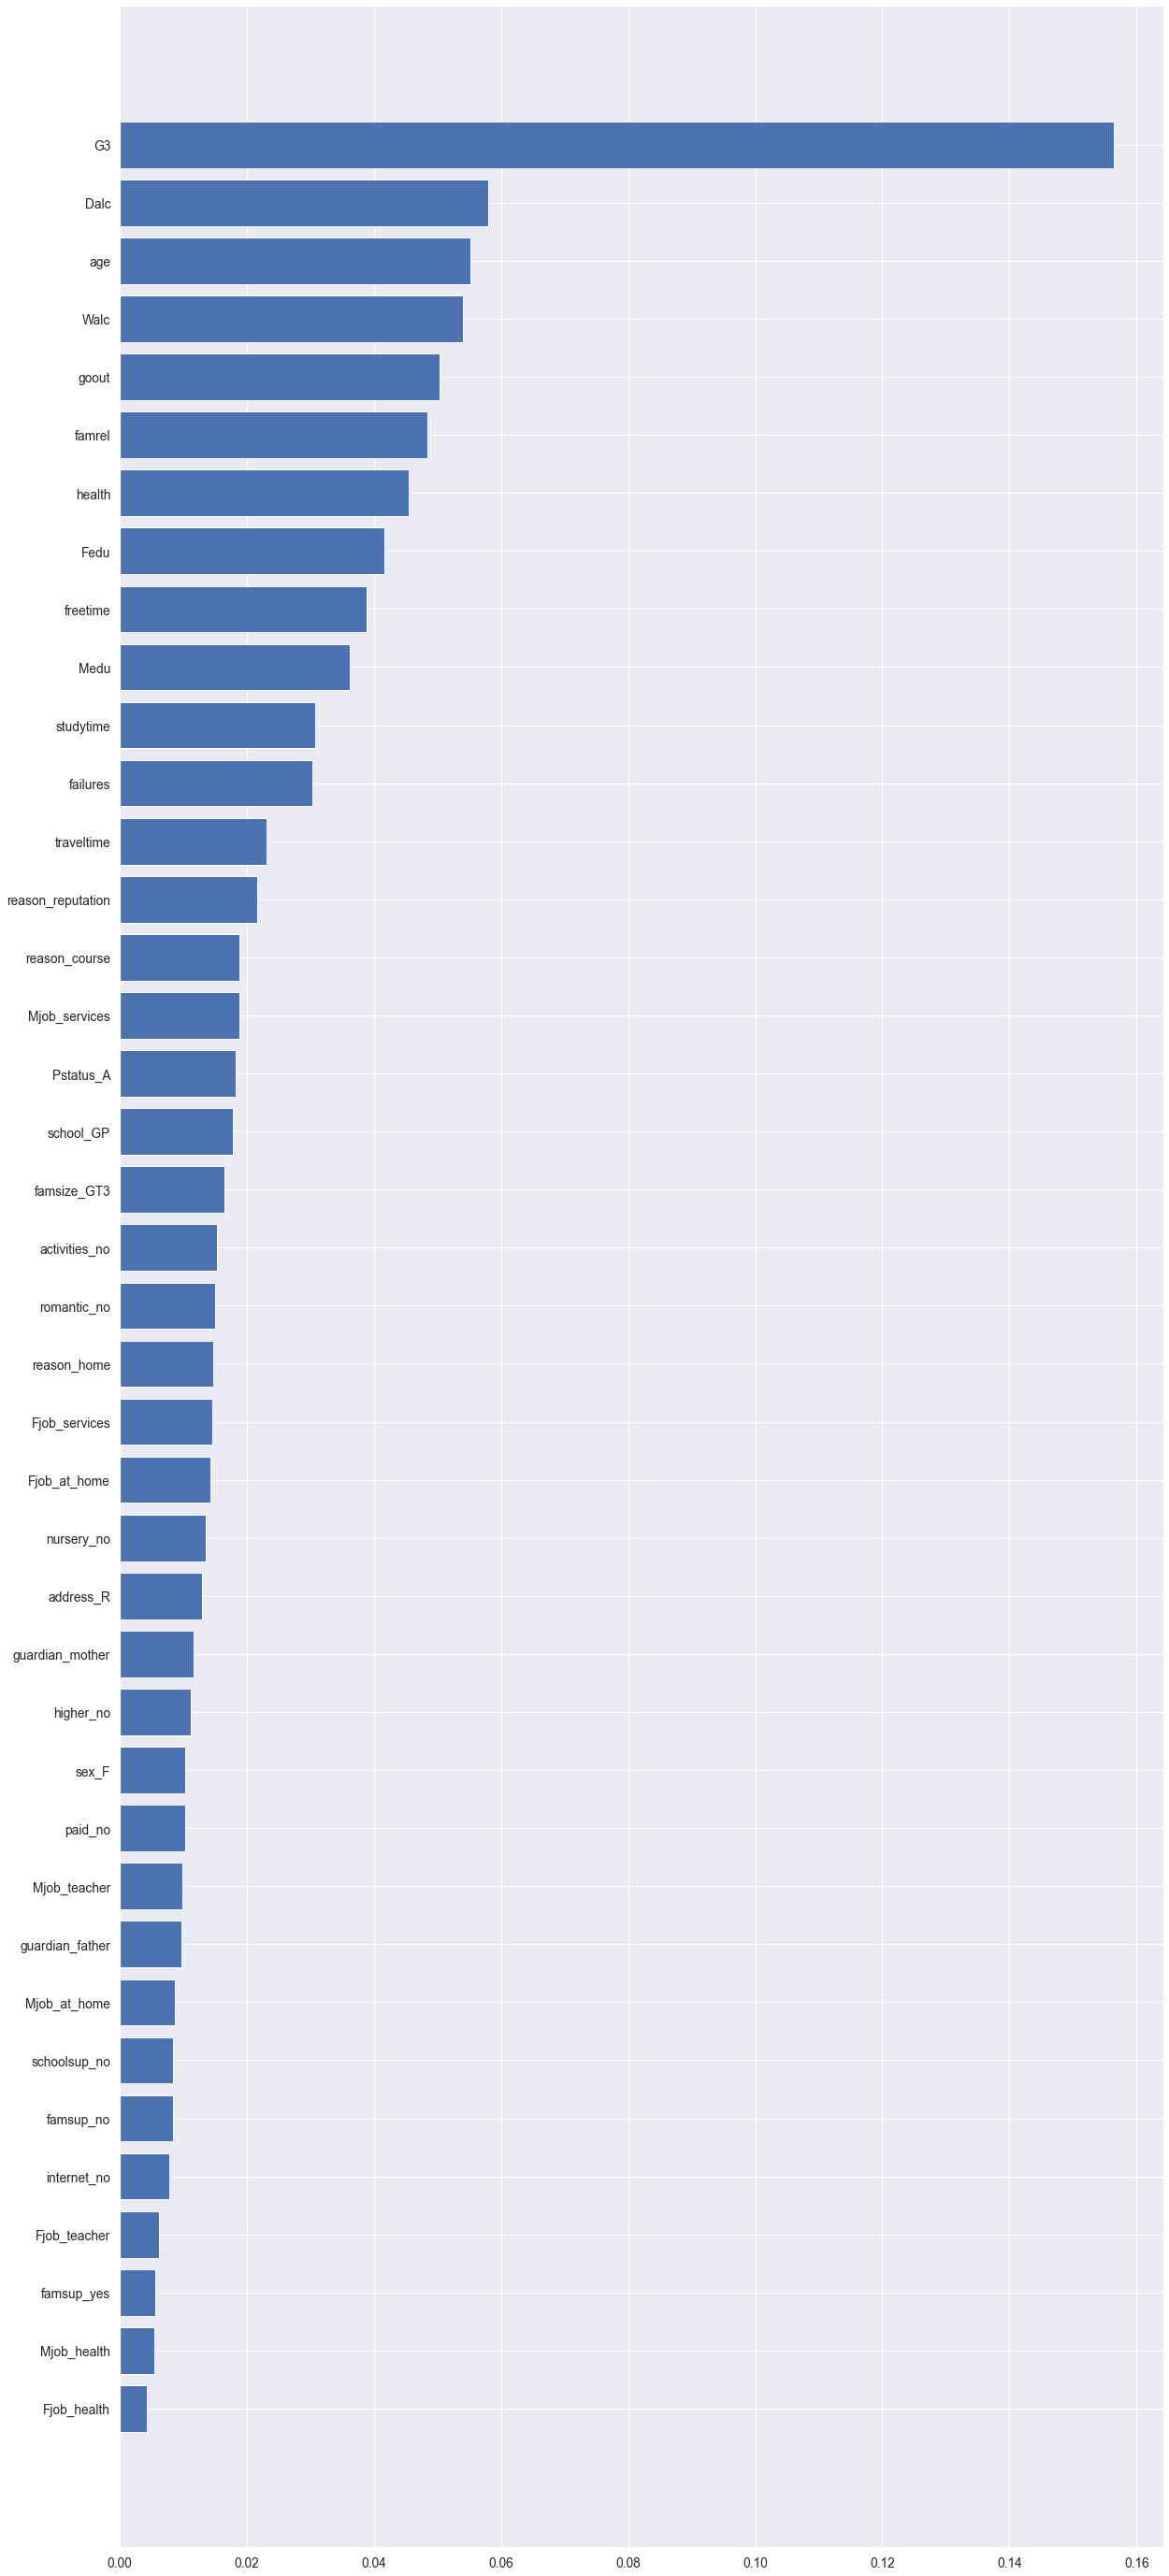

In [164]:
plt.rcParams["figure.figsize"] = (20,50)
plt.barh(X_test.columns[sorted_idx], best_model_RF.best_estimator_.get_params()['RFReg'].feature_importances_[sorted_idx])

## Observation:
* The result is not as exepceted
* However better that ElasticNet

## XGBRegressor


In [165]:
xgb_model = XGBRegressor(random_state=0)

#### Hyper Parameter tuning

In [170]:
search_space = [{'xgb_model': [xgb_model],
                    'xgb_model__learning_rate': [0.01, 0.1, 0.2, 0.3],
                    'xgb_model__max_depth': [3, 5, 7, 10, 25, 50, 100],
                    'xgb_model__min_child_weight': [1, 3, 5],
                    'xgb_model__colsample_bytree': [0.5, 0.7],
                    'xgb_model__objective': ['reg:squarederror']}]

In [171]:
pipe2 = Pipeline(steps=[('xgb_model', xgb_model)])

In [172]:
XGB_GSCV = GridSearchCV(pipe2, search_space, cv=3, verbose=2, n_jobs = -1)

In [173]:
best_model_XGB = XGB_GSCV.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:  1.4min finished


In [174]:
print(best_model_XGB.best_estimator_.get_params()['xgb_model'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [175]:
y_pred_best_model_XGB = best_model_XGB.predict(X_test)

In [176]:
mse_XGBReg = metrics.mean_squared_error(y_test,y_pred_best_model_XGB)

In [177]:
print(np.sqrt(mse_XGBReg ))

3.811516114319269


## Observation:
* The result is not as exepceted
* the result is similar to RandomForestRegressor

# Next steps:
Given more time, the following steps can be tried.
* Feature transformations
* Enhanced Hyperparameter tuning
* Trying other models

## Serving the Machine Learning Model as Rest API

* Serialie the finalized model into pickle file.
* Build a web API app using a Flask framework. This app will use the trained ML pickle file on new data points in real-time.
* Build the docker image Flask application.
* Upload the container onto Google Container Registry (GCR).
* Create a cluster on the Google Kubernetes Engine(GKE).
* Deploy the container image on the created cluseter and expose the app as the REST API to the public.


## Predicting for the Submission

In [178]:
Full_File = pd.concat([stu_por,stu_mat])

In [179]:
Full_File_y = Full_File['absences']

In [180]:
Full_File_X = Full_File.drop(columns=['absences'])

In [181]:
Full_File_X.shape

(1044, 32)

In [182]:
Full_File_X = pd.get_dummies(Full_File_X)

In [183]:
Full_File_X = Full_File_X.drop(columns = ['school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other', 'schoolsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes', 'G1', 'G2' ])

In [184]:
y_pred_final = best_model_XGB.predict(Full_File_X)

In [185]:
Final_mse = metrics.mean_squared_error(Full_File_y,y_pred_final)

In [186]:
print(np.sqrt(Final_mse))

5.4338702146375795


In [187]:
submission_df = pd.DataFrame({'Id': range(1,len(Full_File_y)+1), 'Actual_Absences': Full_File_y, 'Predicted_Absences': np.round(y_pred_final)})

In [117]:
submission_df.to_csv('submission.csv', index=False)